# <center>Portfolio Project: Predicting<br>Loan Risk</center>
Welcome to my portfolio project, where I will build a model to predict which loans are risky. <br>
I will demonstrate the complete data processing pipeline, from data prepration, model fitting and hyperparameter tuning with state-of-the-art gradient boosting machines. <br>
Thank you for your time and reviewing my portfolio! 

**Content:** <br>
1. [Data Info & Setup](#1.)<br>
    1.1 [Creating the Target Variable](#1.1)<br>
    1.2 [Filter data to information available at loan issuance](#1.2)<br>
1. [Exploratory Data Analysis & Data Preparation](#2.)<br>
    2.1 [Text Columns & Feature Engineering](#2.1)<br>
    2.2 [Missing Data](#2.2)<br>
    2.3 [Final Preparations & Train-Test-Split](#2.3)<br>
1. [Modeling](#3.)<br>
    3.1 [Logistic Regression](#3.1)<br>



<a id='1.'></a>

# 1. Data Info & Setup

This is a [publicly available data set](http://https://www.lendingclub.com/auth/login?login_url=%2Finfo%2Fdownload-data.action) from LendingClub, an American peer-to-peer lending company.  I will build a model to predict which loans had been paid back completely and without delay. This will provide valueable information for future loan decisions. 

In [6]:
# Import standard libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp

%matplotlib notebook 
sns.set_style("darkgrid")

In [7]:
# Load the data
df = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)

<a id='1.1'></a>

## 1.1 Creating the Target Variable
There is one variable informing about loan status.
Let's have a closer look: 

In [8]:
df["loan_status"].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

I will use loan_status to create a binary variable, which marks problematic 
loans. This will become my **target variable** for modeling. 

In [9]:
problematic_loans = ["Charged Off", "Default", "In Grace Period", 
                     "Does not meet the credit policy. Status:Charged Off", 
                     "Late (16-30 days)", "Late (31-120 days)"]

df["problematic_loan"] = df["loan_status"].apply(lambda s: int(s in problematic_loans))

In [10]:
# I drop all current loans from analysis. We don't know whether they will 
# become problamtic loans or not and I will therefore exclude them
df = df[df["loan_status"] != "Current"]

<IPython.core.display.Javascript object>


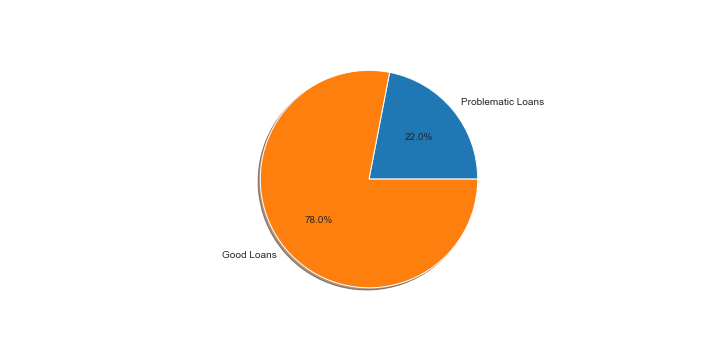

In [11]:
labels = "Problematic Loans", "Good Loans"
sizes = [df["problematic_loan"].sum()/len(df), 1 - df["problematic_loan"].sum()/len(df)]


plt.figure(figsize=(10,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True)

plt.show()

The dataset is slightly imbalanced. I will return to this issue at the end of the data preparation section

<a id='1.2'></a>

## 1.2 Filter data to information available at loan issuance
The original data file contains a lot ofm,ore information which were not available yet at loan issuance. Therefore this information cannot be used to predict loan risk. Through careful inspection, I have created the following list with all variables available at loan issuance and will use it to filter the data.  

In [12]:
available_features = ['acc_now_delinq', 'acc_open_past_24mths', 'addr_state',
 'all_util', 'annual_inc', 'annual_inc_joint', 'application_type', 'avg_cur_bal',
 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
 'delinq_2yrs', 'delinq_amnt', 'desc', 'disbursement_method', 'dti', 'dti_joint',
 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low',
 'funded_amnt', 'grade', 'home_ownership', 'id', 'il_util', 'initial_list_status',
 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt',
 'max_bal_bc', 'member_id', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog',
 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_acc_6m',
 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'pct_tl_nvr_dlq',
 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal',
 'revol_bal_joint', 'revol_util', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med',
 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low',
 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog',
 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util',
 'sub_grade', 'tax_liens', 'term', 'title', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim',
 'total_acc', 'total_bal_ex_mort', 'total_bal_il', 'total_bc_limit', 'total_cu_tl',
 'total_il_high_credit_limit', 'total_rev_hi_lim', 'url', 'verification_status',
 'verification_status_joint', 'zip_code', 'problematic_loan']

In [13]:
df_filter = df[available_features]

In [14]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382384 entries, 0 to 2260700
Columns: 110 entries, acc_now_delinq to problematic_loan
dtypes: float64(89), int64(1), object(20)
memory usage: 1.1+ GB


The file contains over 1 million loans and 109 variables describing each loan and customer. 

<a id='2.'></a>

# 2. Exploratory Data Analysis & Data Preparation

In [15]:
pp.ProfileReport(df_filter)

TypeError: concat() got an unexpected keyword argument 'join_axes'

<a id='2.1'></a>

# 2.1 Text Columns & Feature Engineering

In [137]:
#List all text columns
for c in df_filter.columns:
    if df_filter[c].dtype  == "object":
        print(c, "has", df_filter[c].nunique(), "unique values.")
        if df_filter[c].nunique() < 11: 
                print(df_filter[c].value_counts())

addr_state has 51 unique values.
application_type has 2 unique values.
Individual    1352767
Joint App       29584
Name: application_type, dtype: int64
desc has 124416 unique values.
disbursement_method has 2 unique values.
Cash         1374460
DirectPay       7891
Name: disbursement_method, dtype: int64
earliest_cr_line has 739 unique values.
emp_length has 11 unique values.
emp_title has 385454 unique values.
grade has 7 unique values.
B    400654
C    394346
A    237488
D    209286
E     97559
F     33315
G      9703
Name: grade, dtype: int64
home_ownership has 6 unique values.
MORTGAGE    682142
RENT        550448
OWN         149215
ANY            311
OTHER          182
NONE            53
Name: home_ownership, dtype: int64
id has 1382384 unique values.
initial_list_status has 2 unique values.
w    810885
f    571466
Name: initial_list_status, dtype: int64
purpose has 14 unique values.
sec_app_earliest_cr_line has 585 unique values.
sub_grade has 35 unique values.
term has 2 unique 

### Creating dummy variables 
As we can see abosve, some text columns are binary. I inspected them further and decided to transform the ones which I consider potentially predictive to dummy varibles:

In [138]:
#Creating dummy variables from potentially interesting binary categorical variables: 
df_dummies = pd.get_dummies(df_filter, columns=["term","application_type", 'disbursement_method'])

### Feature Engineering

With more exploration, I identified a few text columns with binary values. 3 text variables which have 
interesting information: <br>
- "purpose" indicates whether a customer already had prior debt
- "home_ownership" indicates whether someone owns a house with or without mortgage 
- "grade" refers to credit score grade <br>
<br>
I transform the first two variables into binary dummy variables and grade into a continuos variable. 

**Prior debt from purpose**

Text(0.5, 1.0, 'Prior Debt')

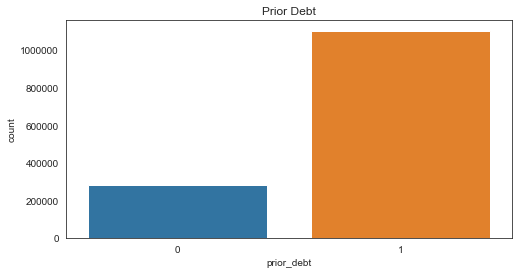

In [139]:
def check_prior_debt(s):
    if s in ["debt_consolidation", "credit_card"]:
        return 1
    else:
        return 0
    
df_dummies["prior_debt"] = df_dummies["purpose"].apply(check_prior_debt)

#Most loaners had prior debt: 
plt.figure(figsize=(8,4))
sns.countplot(df_dummies["prior_debt"])
plt.title("Prior Debt")

**Home ownership and mortgage**

Text(0.5, 1.0, 'Home ownership')

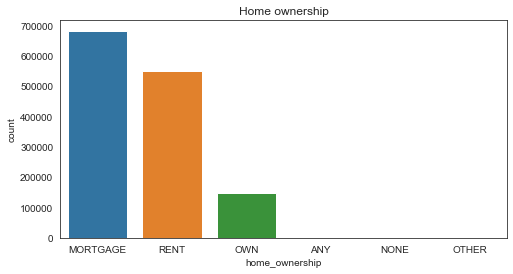

In [140]:
df_dummies["home_owner"] = df_dummies["home_ownership"].apply(lambda s: int(s == "OWN"))
df_dummies["mortgage"] = df_dummies["home_ownership"].apply(lambda s: int(s == "MORTGAGE"))

#Few loaners own a house without mortgage: 
plt.figure(figsize=(8,4))
sns.countplot(df_dummies["home_ownership"])
plt.title("Home ownership")

**Credit Card Score**

In [141]:
df_dummies["grade"].value_counts()

B    400654
C    394346
A    237488
D    209286
E     97559
F     33315
G      9703
Name: grade, dtype: int64

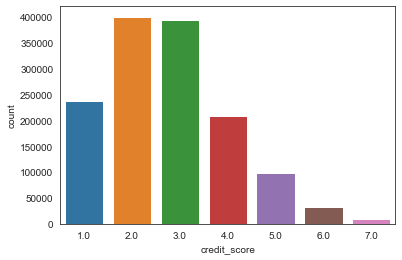

In [142]:
cs_convert = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "NaN": np.nan}
df_dummies["credit_score"] = df_dummies["grade"].apply(lambda s: cs_convert[s] if pd.notnull(s) else s)

sns.countplot(df_dummies[df_dummies["credit_score"].notnull()]["credit_score"])

### Delete text columns
After having engineered new features from some text columns and turned others into dummy variables, 
I will delete all text columns:

In [143]:
#Delete text columns irrelevant for modeling
df_dummies.drop(['id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title', 'sub_grade', 'emp_title', 
         'emp_length', 'purpose', 'addr_state', 'earliest_cr_line', 'sec_app_earliest_cr_line', 'home_ownership', 'home_ownership', 'initial_list_status', 
         'grade', 'verification_status', 'verification_status_joint'], 
        axis=1, inplace=True)

<a id='2.2'></a>

### 2.2 Missing Data

Over 2 million loans is a lot of data to process. To speed up the subsequent modeling process, I will delete rows and columns with a lot of missings.

**Missings per column**

Text(0.5, 0, 'Columns')

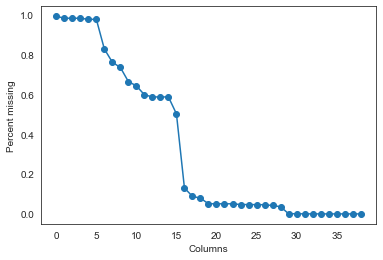

In [144]:
missings_column = df_dummies.isnull().sum(axis=0).unique().tolist()
#Get the percentage of missing values per column
plt.plot([s/len(df_dummies) for s in sorted(missings_column, reverse=True)], marker="o")
plt.ylabel("Percent missing")
plt.xlabel("Columns")

There are columns with many missing but then there is a sudden drop from 50% to 13% missing. I will exclude all columns with more than 50% missing:

In [182]:
df_nomiss = df_dummies.dropna(axis=1, thresh=df_dummies.shape[0]*.50)

**Missings per row**

Text(0.5, 0, 'Rows')

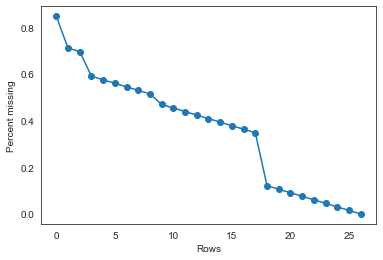

In [173]:
missings_row = df_nomiss.isnull().sum(axis=1).unique().tolist()
#Get the percentage of missing values per column
plt.plot([s/df_nomiss.shape[1] for s in sorted(missings_row, reverse=True)], marker="o")
plt.ylabel("Percent missing")
plt.xlabel("Rows")

There is a jump from around 35% to 12% missing in a row. I will drop all cases with at least 35% missing. 

In [183]:
df_nomiss = df_nomiss.dropna(axis=0, thresh=0.6*df_nomiss.shape[1])

*Quick look at the proprocessed data:*

In [184]:
df_nomiss.shape

(1332067, 66)

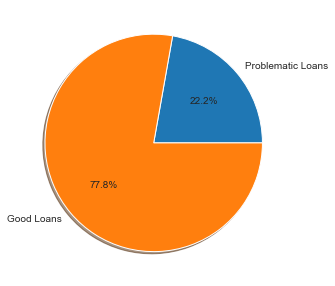

In [185]:
labels = "Problematic Loans", "Good Loans"
sizes = [df_nomiss["problematic_loan"].sum()/len(df_nomiss), 1 - df_nomiss["problematic_loan"].sum()/len(df_nomiss)]


plt.figure(figsize=(10,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True)

plt.show()

The removal of rows and columns based on missings has not changed the relative amount of problematic loans. This is good because there was no systematic connection between the problematic loans and these missing data. There are still over 1.3 million cases and 65 features.  

<a id='2.3'></a>

## 2.3 Undersampling & Train-Test-Split

1.3 million cases is a lot and will slow down modeling. I will reduce it to approximately 200,000 cases.

This is also an imbalanced dataset where the target "problematic loans" is underrepresented by a ratio of about  4:1. There is no a-priori way of knowing whether the imbalance will negatively affect model performance. Furthermore, some models also have built-in "cost-senstive" techniques which give more weight to the underrepresented class. Thus, I will create **a balanced resampled dataset and an imbalanced resampled dataset** (leaving the distribution "as is") and will train and test with both, to find the best model fit. 

**Balanced Resampled Dataset**

In [186]:
good_loans = df_nomiss[df_nomiss["problematic_loan"] == 0]
problematic_loans = df_nomiss[df_nomiss["problematic_loan"] == 1]

In the next step, I resample a higher fraction from the problematic loans, which results in a balanced dataset.

In [187]:
balanced_subsample_good = good_loans.sample(frac = 0.1)
balanced_subsample_problematic = problematic_loans.sample(frac = 0.3)

In [188]:
balanced_subsample = pd.concat([balanced_subsample_problematic, balanced_subsample_good])

In [189]:
balanced_subsample.shape

(192387, 66)

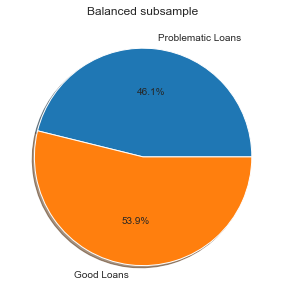

In [190]:
labels = "Problematic Loans", "Good Loans"
sizes = [balanced_subsample["problematic_loan"].sum()/len(balanced_subsample), 1 - balanced_subsample["problematic_loan"].sum()/len(balanced_subsample)]


plt.figure(figsize=(10,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True)
plt.title("Balanced subsample")
plt.show()

In [191]:
y_balanced = balanced_subsample["problematic_loan"]
X_balanced = balanced_subsample.drop("problematic_loan", axis=1)

**Imbalanced Resampled Dataset**

This time I will use the separate datasets for good and problematic to ensure that the distributions are preserved.

In [192]:
imbalanced_subsample_good = good_loans.sample(frac = 0.15)
imbalanced_subsample_problematic = problematic_loans.sample(frac = 0.15)

In [193]:
imbalanced_subsample = pd.concat([imbalanced_subsample_problematic, imbalanced_subsample_good])

In [194]:
imbalanced_subsample.shape

(199810, 66)

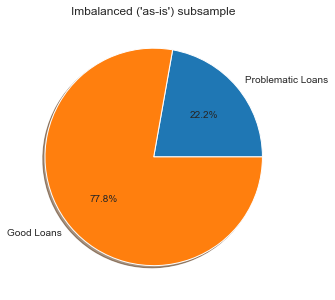

In [195]:
labels = "Problematic Loans", "Good Loans"
sizes = [imbalanced_subsample["problematic_loan"].sum()/len(imbalanced_subsample), 1 - imbalanced_subsample["problematic_loan"].sum()/len(imbalanced_subsample)]


plt.figure(figsize=(10,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True)
plt.title("Imbalanced ('as-is') subsample")
plt.show()

In [196]:
y_imbalanced = imbalanced_subsample["problematic_loan"]
X_imbalanced = imbalanced_subsample.drop("problematic_loan", axis=1)

**Train-Test-Split**

A common procedure is to split the the data into a training set, which is used to train model, and an independent test set, which is subsequently used to evaluate model performance.

A usual split is to reserve 30-40% for testing. However, this is still a large dataset so I will reduce the test sample to 20%. I will use stratification to preserve the relative amount of problematic and good loans in both sets. 

In [197]:
from sklearn.model_selection import train_test_split

In [198]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.20, stratify=y_balanced)

In [199]:
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imbalanced, y_imbalanced, test_size=0.20, stratify=y_imbalanced)

I will  save the preprocessed and subsampled dataset, so it is possible later to continue this project directly from here without the need to repeat all preprocessing steps. 

In [200]:
X_train_imb.to_pickle("LoansData_ImbalancedSubsample_Xtrain.pkl")
y_train_imb.to_pickle("LoansData_ImbalancedSubsample_ytrain.pkl")
X_test_imb.to_pickle("LoansData_ImbalancedSubsample_Xtest.pkl")
y_test_imb.to_pickle("LoansData_ImbalancedSubsample_ytest.pkl")

X_train_imbal.to_pickle("LoansData_BalancedSubsample_Xtrain.pkl")
y_train_imbal.to_pickle("LoansData_BalancedSubsample_ytrain.pkl")
X_test_imbal.to_pickle("LoansData_BalancedSubsample_Xtest.pkl")
y_test_imbal.to_pickle("LoansData_BalancedSubsample_ytest.pkl")

Next I will do some "housekeeping" and delete dataframes from memory which are not used any more. 

In [201]:
#Save the feature names (will be useful later)
features = list(df_nomiss)

#delete dataframes
del df
del df_filter
del df_dummies
del df_nomiss
del good_loans
del problematic_loans
del balanced_subsample_good
del balanced_subsample_problematic
del X_balanced
del y_balanced
del imbalanced_subsample_good
del imbalanced_subsample_problematic
del X_imbalanced
del y_imbalanced

#One of Python's "weak" spots is its handling of RAM, as it does not 
#free up memory space when variables are deleted. I will load a "garbage collection"
#module to take care of this

import gc

gc.collect()

10053

**Save Point**

Running the next cell will make it possible to continue this project from here: 

In [1]:
# Import libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
%matplotlib inline
sns.set_style("white")

# Load files
X_train_imb = pd.read_pickle("LoansData_ImbalancedSubsample_Xtrain.pkl")
y_train_imb = pd.read_pickle("LoansData_ImbalancedSubsample_ytrain.pkl")
X_test_imb = pd.read_pickle("LoansData_ImbalancedSubsample_Xtest.pkl")
y_test_imb = pd.read_pickle("LoansData_ImbalancedSubsample_ytest.pkl")
X_train_bal = pd.read_pickle("LoansData_BalancedSubsample_Xtrain.pkl")
y_train_bal = pd.read_pickle("LoansData_BalancedSubsample_ytrain.pkl")
X_test_bal = pd.read_pickle("LoansData_BalancedSubsample_Xtest.pkl")
y_test_bal = pd.read_pickle("LoansData_BalancedSubsample_ytest.pkl")

<a id='3.'></a>

# 3. Modeling

A few years ago, I would have employed a whole range of machine learning algorithms, such as logistic regression, Support-Vector-Machines, or Random Forest. While I could do this, Kaggle and other Machine Learning competitions have shown repeatedly that one can get better accuracy by employing Gradient Boosting Machines (GBM), and  instead of trying different "classical" machine linearning models spending time with model optimization, e.g. by tuning hyperparameters. 

A GBM is a sequential ensemble learening method, which is built around a loss function, weak learners, and additive model to add weak learners to minimize the loss function. Most suited to this procedure are Decision trees as weak learners. 

I will demonstrate these techniques with one of the most successfull GBM's, XGBoost, including stratified cross validation, tuning of hyperparameters, and model evaluation. 

<a id='3.1'></a>

## 3.1 Logistic Regression

Logistic regression attempts to minimize the squared distances between predictions and actual outcomes using a Sigmoid function. There are two additional preprocessing steps need for logistic regression to work optimally: Stanardization of predictor and impuation of all missing values. 

I will use cross-valdiation to fit the model. This is a technique where the model is fit several to different parts of the data. The final model parameters are based on the means of all these different models, which reduces the model's variance or dependency on a specific dataset.

*Risk of Data Leakage:*
Preprocessing steps like standardization and normalization bring the danger of data leakage, especially when combined with cross-validation. This happens when these preprocessing steps are performed before the data is split into the training and validation set. In this case, information from the validation set has "leaked" into the training set. This can be circumvented by using "pipelines", where these preprocessing steps are performed separately for each training dataset. 

*Tuning of hyperparamters:*
Finally, I will also employ GridSearch. This is a technique where several models with different hyperparameters are trained to find the configuration with the best fit. Hyperparameters are parameters which concern the general model layout but cannot be adjsuted by training. "Tuning" of hyperparamters can quickly become computationally expensive, so I will focus on a few of the most important ones for each model. 

I will perform the whole modeling process for both the imbalanced and balanced subsamples. Logistic regression also has an inherent way of dealing with imbalanced datasets (using weighting), and it will be interesting to see whether one approach performs better than the other. In summary, these are the steps for logistic regression: 
- Standardization of predictor variables
- Imputation of missing values
- Model fitting with k-fold cross validation
- GridSearch for hyperparameter tuning
- Combine all the steps from above in a "pipeline" to prevent data leaking.
- Model evaluation with F1-scores and confusion matrices

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, f1_score

**Balanced dataset**

In [3]:
#Definition of pipleline and the hyperparamters for tuning
pipe_reg_bal = Pipeline([("standardizer", StandardScaler()), ("mean_impute", SimpleImputer()), 
                     ("reg_model", LogisticRegression(solver="saga"))])
param_grid_reg = {"reg_model__C":[1.0, 1.5, 2.0], "reg_model__penalty":["l1", "l2"]}

In [4]:
grid_reg_bal = GridSearchCV(pipe_reg_bal, param_grid=param_grid_reg, cv=5, verbose = 1, n_jobs=-1)
grid_reg_bal.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardizer',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('mean_impute',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('reg_model',
                                        LogisticRegression(C=1.0,
                                                         

**Imbalanced Dataset**

In [ ]:
#Definition of pipleline for imbalanced dataset
pipe_reg_imb = Pipeline([("standardizer", StandardScaler()), ("mean_impute", SimpleImputer()), 
                     ("reg_model", LogisticRegression(solver="saga", class_weight="balanced"))])

In [8]:
grid_reg_imb = GridSearchCV(pipe_reg_imb, param_grid=param_grid_reg, cv=5, verbose = 1, n_jobs=-1)
grid_reg_imb.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardizer',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('mean_impute',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('reg_model',
                                        LogisticRegression(C=1.0,
                                                         

**Evaluation of Logistic Regression Models**

Text(0.5, 1.0, 'Balanced Subsampling\n\nOptimal hyperparameters:\nC=2.0, penalty=l2\n\nF1-Score = 0.65')

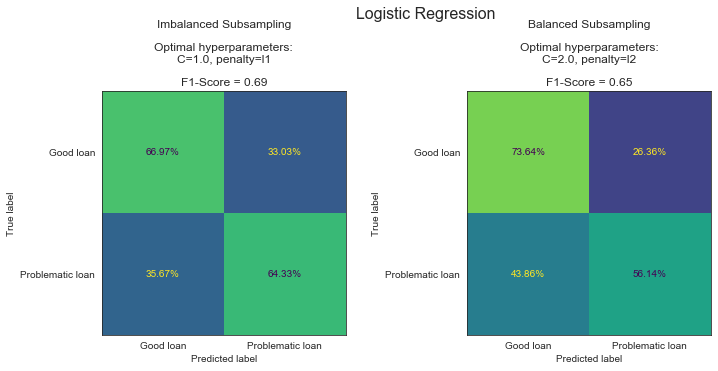

In [143]:
#Preparation of text output
f1_reg_imb = f1_score(y_test_imb, grid_reg_imb.predict(X_test_imb), average="weighted")
f1_reg_bal = f1_score(y_test_bal, grid_reg_bal.predict(X_test_bal), average="weighted")
title_reg_imb = 'Imbalanced Subsampling\n\n' + 'Optimal hyperparameters:\n' + ', '.join("{}={}".format(key[11:],val) for (key,val) in grid_reg_imb.best_params_.items()) + '\n\nF1-Score = ' + str(round(f1_reg_imb, ndigits=2))
title_reg_bal = 'Balanced Subsampling\n\n' + 'Optimal hyperparameters:\n' + ', '.join("{}={}".format(key[11:],val) for (key,val) in grid_reg_bal.best_params_.items()) + '\n\nF1-Score = ' + str(round(f1_reg_bal, ndigits=2))

#Creating the figure
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.suptitle('Logistic Regression', fontsize =16)

#imbalanced classifiction (left side)
pcm_imb = plot_confusion_matrix(grid_reg_imb, X_test_imb, y_test_imb, normalize="true", ax = ax[0], values_format=".2%", display_labels=["Good loan", "Problematic loan"])
pcm_imb.im_.set_clim(0.1,0.9)
pcm_imb.im_.colorbar.remove()
ax[0].set_title(title_reg_imb)

#balanced classification (right side)
pcm_bal = plot_confusion_matrix(grid_reg_bal, X_test_bal, y_test_bal, normalize="true", ax = ax[1], values_format=".2%", display_labels=["Good loan", "Problematic loan"])
pcm_bal.im_.set_clim(0.1,0.9)
pcm_bal.im_.colorbar.remove()
#pcm_bal.im_.axes.yaxis.set_visible(False)
ax[1].set_title(title_reg_bal)

**Conclusion for Logistic Regression**

The F1-scores can be interpreted as a weighted average of the precision and recall, and thereby as an overall performance score, according to which the imbalanced subsampling led to a slightly better classification.  
In the confusion matrices, we see the classication  for imbalanced (left) and balanced subsampling (right). while the imbalanced subsampling led to a slightly better sensitivity of 64% (percentage of problematic loans correctly identified), it did so at the cost of an increased rate of false positives (33% vs 26%). 
Neither of the two logistic regression models performed very good. Regression models make a lot of assumptions about the predictor variables, e.g. normally distributed, independent from one another (no multicollinearity), homoscedastictiy. Carefullying checking these and correcting whenever possible might lead to some improvements. However, while logistic regression is "the classic classifier", nowadays there are more modern approaches which often outperform regression. 
I will move on to Support Vector Classifier and Gradient Boosting Machines, two machine learning algorithms which generally perform well and also are good complementary strategies to logsitic regression (e.g. see [Olson et al., 2017](https://arxiv.org/abs/1708.05070)). 
